In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
# load utils
import utils as ut
pd.set_option('display.max.columns', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Carga de archivos de los resultados, los resultados estan desagregados, entre drop3 y entropy.

In [2]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
entropy_results = ut.read_results("./data/is_experiments",  ["susyAllResults.csv"])
condition = (entropy_results.isMethod != 'drop3') & (entropy_results.instanceSelection != 'NOIS')
no_is_results =  entropy_results[entropy_results.instanceSelection == 'NOIS'].copy().reset_index(drop= True)
entropy_results = entropy_results[condition].copy().reset_index(drop= True)


In [3]:
entropy_results.groupby(['database', 'instanceSelection', 'imbalance', 'lshMEthod'])['tp'].count().reset_index()

,database,instanceSelection,imbalance,lshMEthod,tp
0,fraudk,IS,False,hyperplanes,450
1,fraudk,IS,False,hyperplanes-projection,450
2,fraudk,IS,False,projection,450
3,fraudk,IS,True,hyperplanes,450
4,fraudk,IS,True,hyperplanes-projection,450
5,fraudk,IS,True,projection,450
6,p2p,IS,False,hyperplanes,553
7,p2p,IS,False,hyperplanes-projection,514
8,p2p,IS,False,projection,502
9,p2p,IS,True,hyperplanes,532


Ahora todos los resultados de drop3

In [4]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
drop3_files = ['boundaries.csv', "one.csv", "test.csv"]
drop3_results = ut.read_results("./data/drop3",  drop3_files)
condition = (drop3_results.isMethod == 'drop3') & (drop3_results.instanceSelection != 'NOIS')
drop3_results = drop3_results[condition].copy().reset_index(drop= True)
# in the drop3 the file have the db and the
# one sample bucket
drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)

In [5]:
drop3_results.groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'imbalance', 
                        'lshMEthod'])['tp'].count().reset_index()

,database,instanceSelection,one_class_method,imbalance,lshMEthod,tp
0,fraudk,IS,boundaries,True,hyperplanes,468
1,fraudk,IS,boundaries,True,hyperplanes-projection,468
2,fraudk,IS,boundaries,True,projection,450
3,fraudk,IS,one,True,hyperplanes,720
4,fraudk,IS,one,True,hyperplanes-projection,720
5,fraudk,IS,one,True,projection,720
6,p2p,IS,boundaries,True,hyperplanes,124
7,p2p,IS,boundaries,True,hyperplanes-projection,108
8,p2p,IS,boundaries,True,projection,108
9,p2p,IS,one,True,hyperplanes,202


Now We will concatenate the results



In [6]:
entropy_results['one_class_method'] = 'entropy'
drop3_entropy = pd.concat([entropy_results, drop3_results], ignore_index=True)
# deduplicate records
drop3_entropy = drop3_entropy.drop_duplicates()

In [7]:
## add axiliary results        
drop3_entropy['Total Time'] = drop3_entropy.timeLSH + drop3_entropy.timeIS
drop3_entropy['total'] = drop3_entropy.tp + drop3_entropy.tn + drop3_entropy.fn + drop3_entropy.fp
drop3_entropy['samples by bucket average (relative)'] = drop3_entropy.buckAvg/drop3_entropy.total*100.0
drop3_entropy['model_complexity'] =  drop3_entropy.trees*drop3_entropy.depth
drop3_entropy['Reduction of DataSet(%)'] = (1 - drop3_entropy['reduction'])*100.0

## Results Plots

In [54]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'one_class_method']
measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'timeIS', 'model_complexity']
factorsModel = ['trees', 'depth']

factorsNoIS = ['database']
measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC']

best_no_is = (no_is_results.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, measuresNoIS, factorsModel = factorsModel))
                .reset_index())


In [55]:
best_no_is

,database,trees,depth,tp,tn,fp,fn,sensibility,specificity,precision,accuracy,F1,Gmean,wtdAcc,AreaROC,type
0,fraudk,50,20,76.720000,56857.873333,76.720000,21.680000,78.055187,99.865237,50.0,99.827450,60.941553,88.279571,84.598202,0.969058,Test
1,fraudk,50,20,390.613333,227450.826667,390.613333,2.986667,99.242307,99.828558,50.0,99.827545,66.497177,99.534784,99.418183,0.998496,Train
2,pageblocks,25,30,96.833333,970.026667,96.833333,14.966667,86.566585,90.910717,50.0,90.508109,63.354967,88.679674,87.869825,0.936847,Test
3,pageblocks,25,30,442.186667,3921.746667,442.186667,5.013333,98.876897,89.866752,50.0,90.704529,66.415003,94.263981,96.173853,0.990647,Train


In [22]:
aspect = 1.5
sns.set(font_scale=1.3, style='white')

def get_result_plot(df, measure, cond):
    data = (drop3_entropy[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = measure, factorsModel = factorsModel))
                .reset_index())
    data['is'] = data['one_class_method']

    g= sns.relplot(x="ands", y=measure, hue = 'lshMEthod', 
            style = 'type', 
            aspect=aspect, 
            row = 'database', 
            col = 'is',
            kind = 'line',
            data=data,
            legend = 'full', markers = True, facet_kws = {'sharey': 'row'})
    ut.increase_lw(g)
    plt.show()
    return(g)


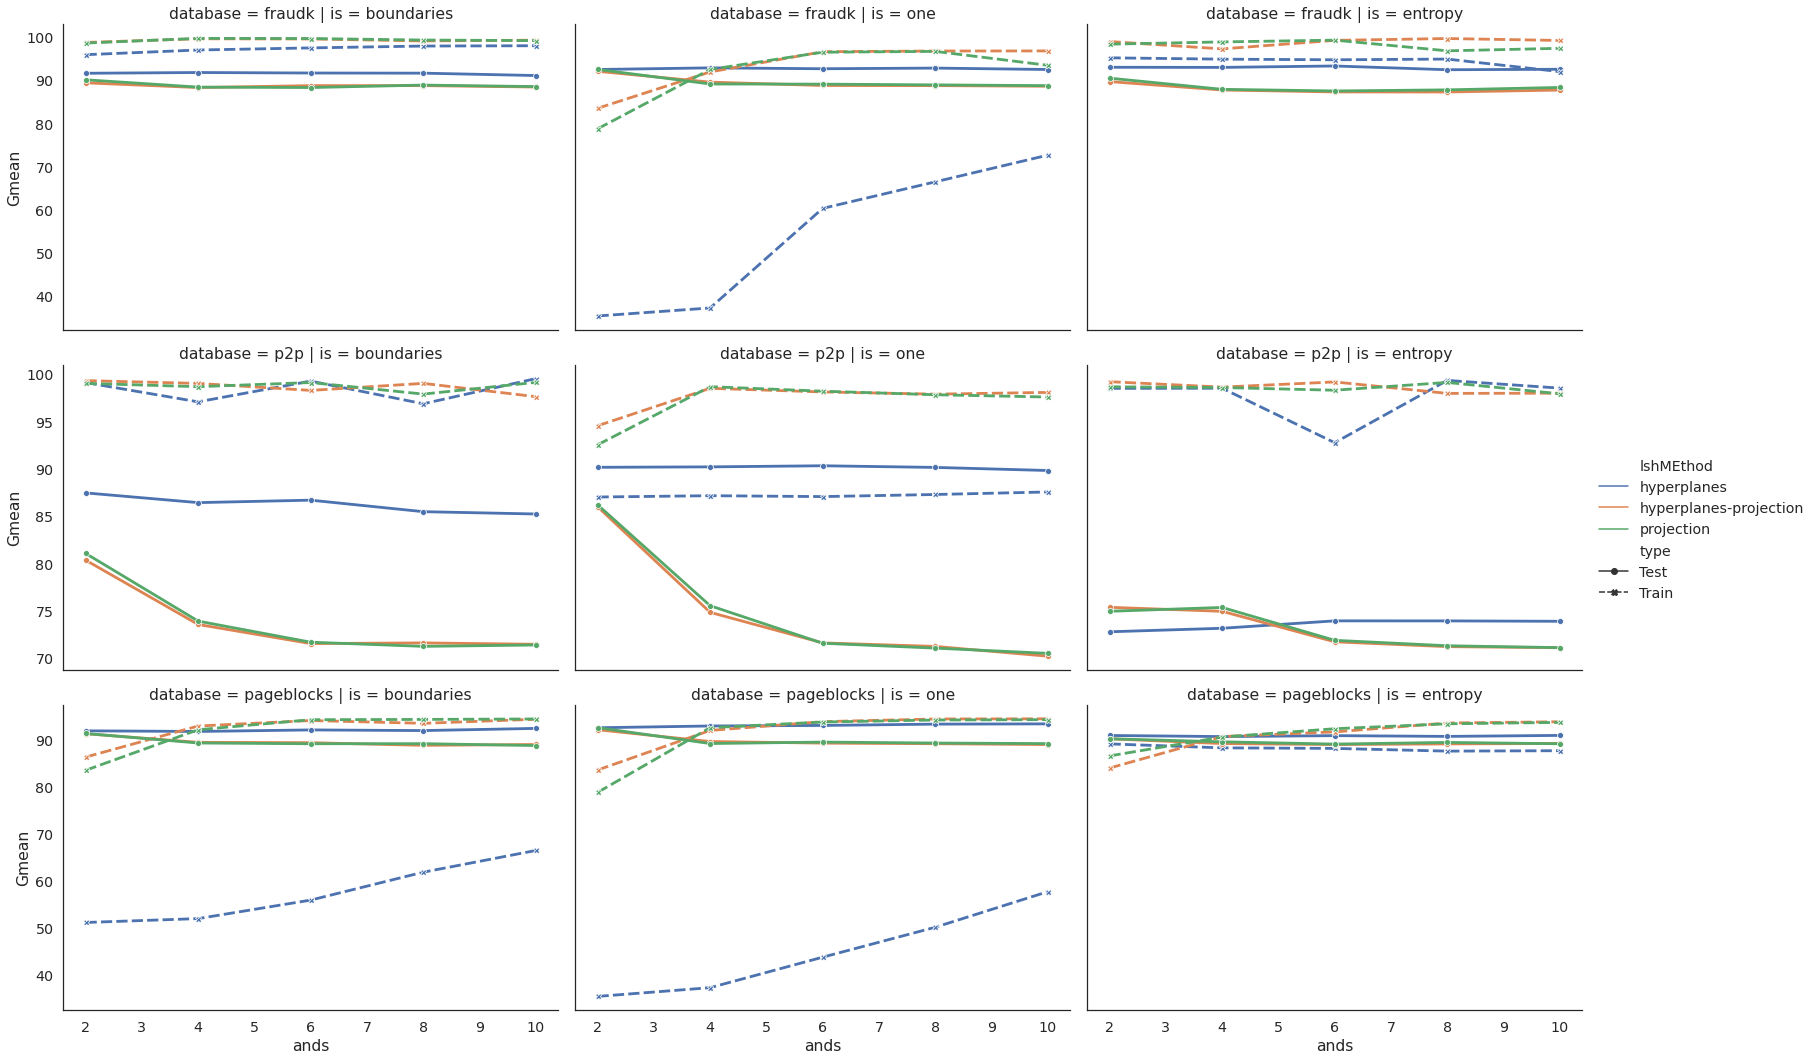

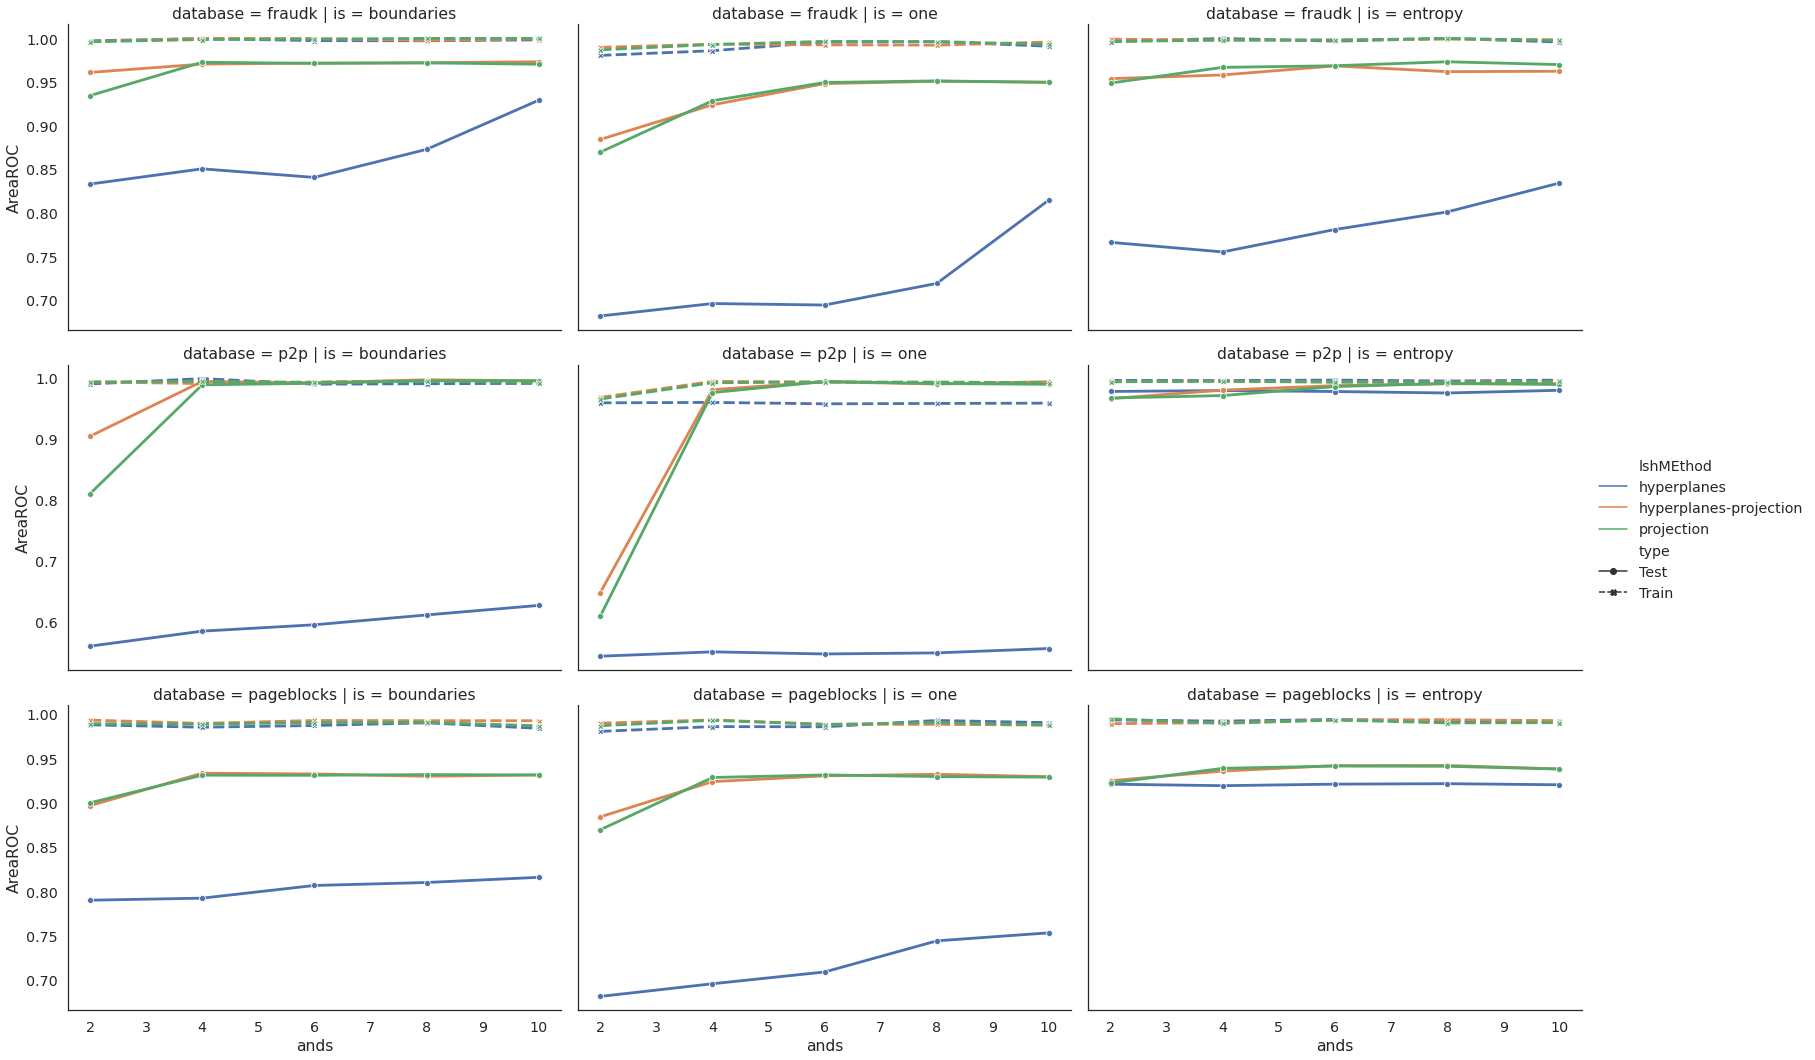

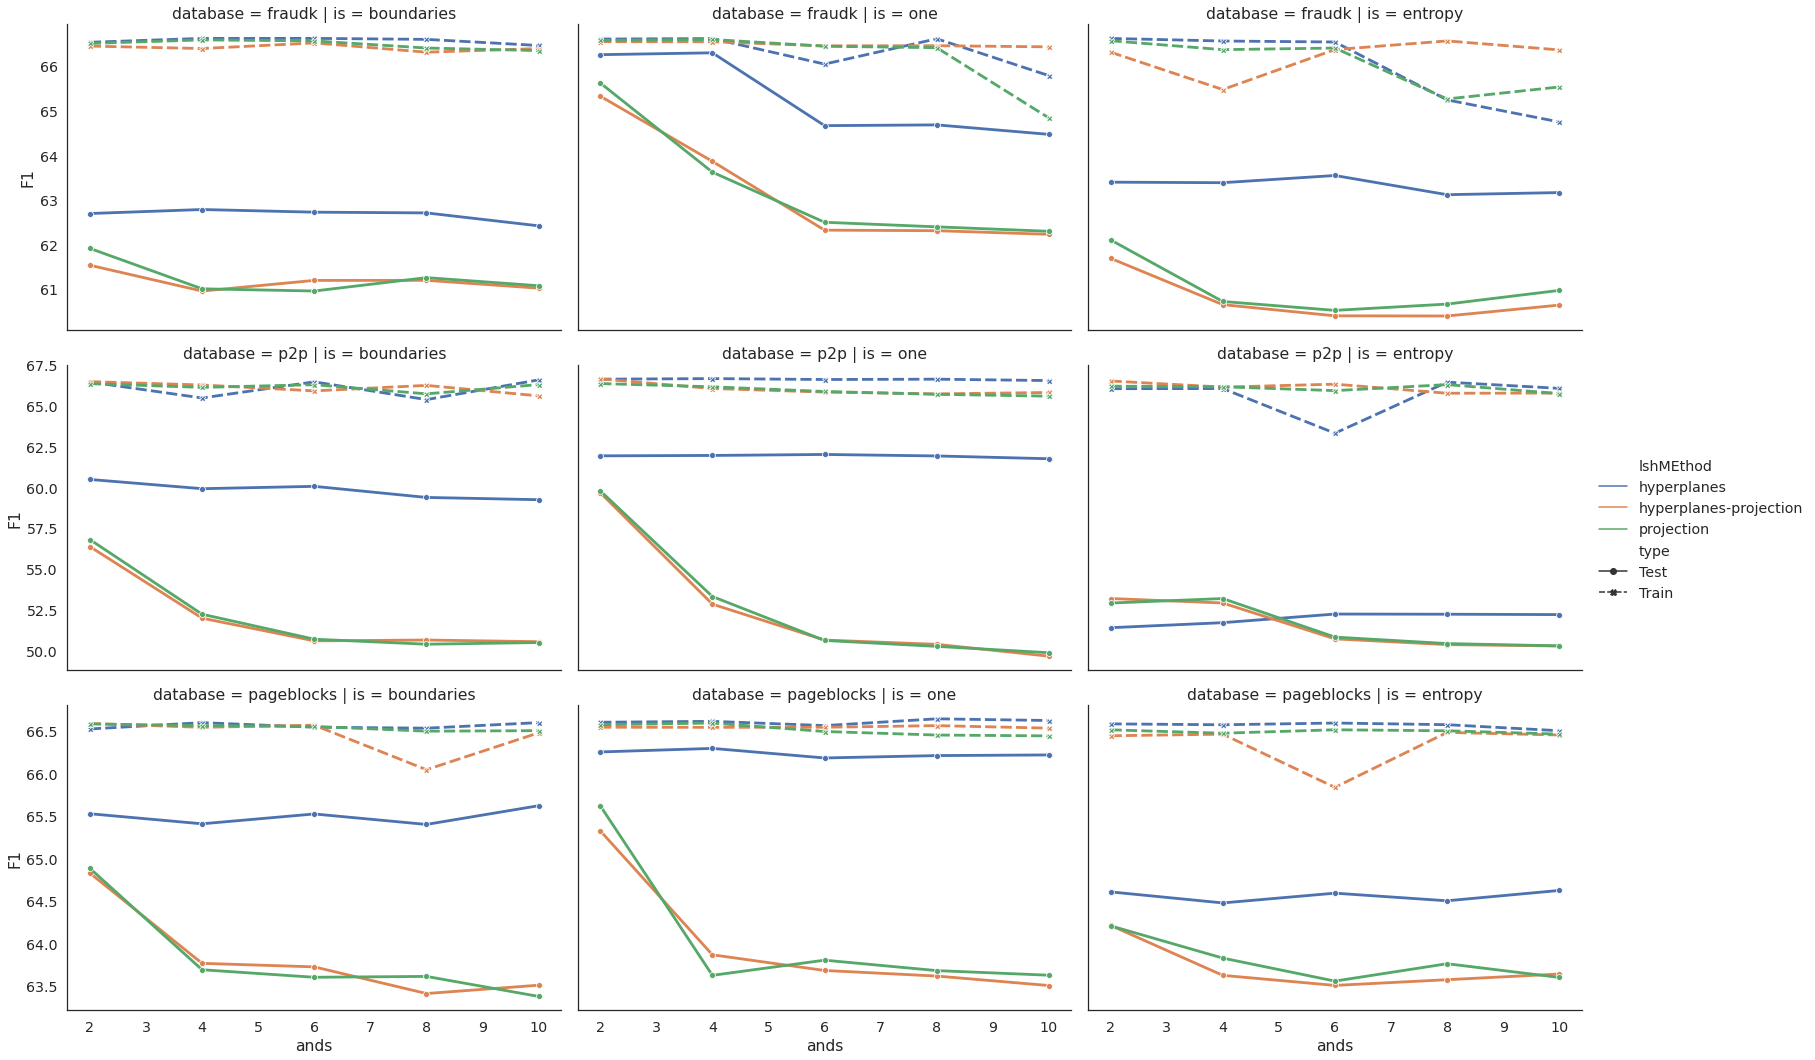

In [23]:
cond= drop3_entropy.imbalance == True
g1 = get_result_plot (best_no_is, "Gmean", cond)
g2 = get_result_plot (best_no_is, "AreaROC", cond)
g3 = get_result_plot (best_no_is, "F1", cond)


In [43]:
def get_db_from_ax(ax) :
    db_str = ax.title.get_text()
    db = db_str.split(" | ")[0].split("=")[1].strip()
    return (db)

axs = np.ravel(g1.axes)

In [52]:
db = get_db_from_ax(axs[1])
best_no_is.loc[best_no_is.database==db, ['ands', 'Gmean' 'type']]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Gmeantype'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [48]:
len(axs)

9

In [39]:
import plotly.graph_objects as go
categories =['lshMEthod', 'one_class_method', 'ands']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=data['Gmean'],
      theta=data[['one_class_method', 'lshMEthod']],
      fill='toself',
      name='one_class_method'
))
fig.add_trace(go.Scatterpolar(
      r=data['Gmean'],
      theta=categories,
      fill='toself',
      name='ands'
))


fig.show()